In [2]:
import pandas as pd
import numpy as np
import joblib
import math
from keras.models import load_model
import random
import tensorflow as tf

import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 전처리 끝낸 데이터
df_train = joblib.load('df_train.pkl')
df_test = joblib.load('df_test.pkl')


In [3]:
df2 = df_train.copy()

# Bi-directional LSTM 모델링(분류)

# Bi-directional LSTM 모델링(회귀)

In [10]:
# 시드 설정
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 시퀀스 생성 함수 정의
def create_sequences(data, sequence_length, target_column):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length, :-1])
        targets.append(data[i + sequence_length, target_column])
    return np.array(sequences), np.array(targets)

# 시정 구간 분류 함수 정의
def classify_visibility(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4
    

columns = ['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts', 'dew_point']
sequence_length = 35 # 6시간

In [5]:
# 필요한 열만 선택
columns = ['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts', 'dew_point']
train_data = df_train[columns + ['vis1']].values

# 시퀀스 생성
sequence_length = 35 # 6시간
X, y = create_sequences(train_data, sequence_length, -1)

# y 값을 클래스(범주)로 변환
y_classes = np.array([classify_visibility(vis) for vis in y])

# 학습, 검증, 테스트 데이터 분리 (클래스 비율 유지)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y_classes)
y_train_val_classes = np.array([classify_visibility(vis) for vis in y_train_val])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=seed, stratify=y_train_val_classes)


In [6]:
'''
# 일정 간격으로 데이터 분리
def split_data(X, y, test_size=0.2, val_size=0.2, random_seed=seed):
    np.random.seed(random_seed)
    data_size = len(X)
    indices = np.arange(data_size)
    np.random.shuffle(indices)

    test_split = int(data_size * test_size)
    val_split = int(data_size * (test_size + val_size))

    test_indices = indices[:test_split]
    val_indices = indices[test_split:val_split]
    train_indices = indices[val_split:]

    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
'''

'\n# 일정 간격으로 데이터 분리\ndef split_data(X, y, test_size=0.2, val_size=0.2, random_seed=seed):\n    np.random.seed(random_seed)\n    data_size = len(X)\n    indices = np.arange(data_size)\n    np.random.shuffle(indices)\n\n    test_split = int(data_size * test_size)\n    val_split = int(data_size * (test_size + val_size))\n\n    test_indices = indices[:test_split]\n    val_indices = indices[test_split:val_split]\n    train_indices = indices[val_split:]\n\n    X_train, y_train = X[train_indices], y[train_indices]\n    X_val, y_val = X[val_indices], y[val_indices]\n    X_test, y_test = X[test_indices], y[test_indices]\n\n    return X_train, X_val, X_test, y_train, y_val, y_test\n\nX_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)\n'

In [7]:
# LSTM 모델 정의(지희)
model = Sequential()
model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=True), input_shape=(sequence_length, len(columns))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(16, activation='tanh')))
model.add(Dropout(0.3))
model.add(Dense(1))  # vis1 예측이므로 출력 뉴런은 1개

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [8]:
# # 양방향 LSTM 모델 구성(나)
# model = Sequential()
# model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=True), input_shape=(sequence_length, X_train.shape[-1]))) # X_train.shape[-1]대신 len(columns)
# model.add(Dropout(0.2))  # Dropout 추가
# model.add(Bidirectional(LSTM(16, activation='tanh')))
# model.add(Dropout(0.2))  # Dropout 추가
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               verbose=1, # 로그출력
                               restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, callbacks=[early_stopping]) # epochs=100


Epoch 1/100
4735/4735 [==============================] - 164s 31ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
4735/4735 [==============================] - 95s 20ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
4735/4735 [==============================] - 81s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


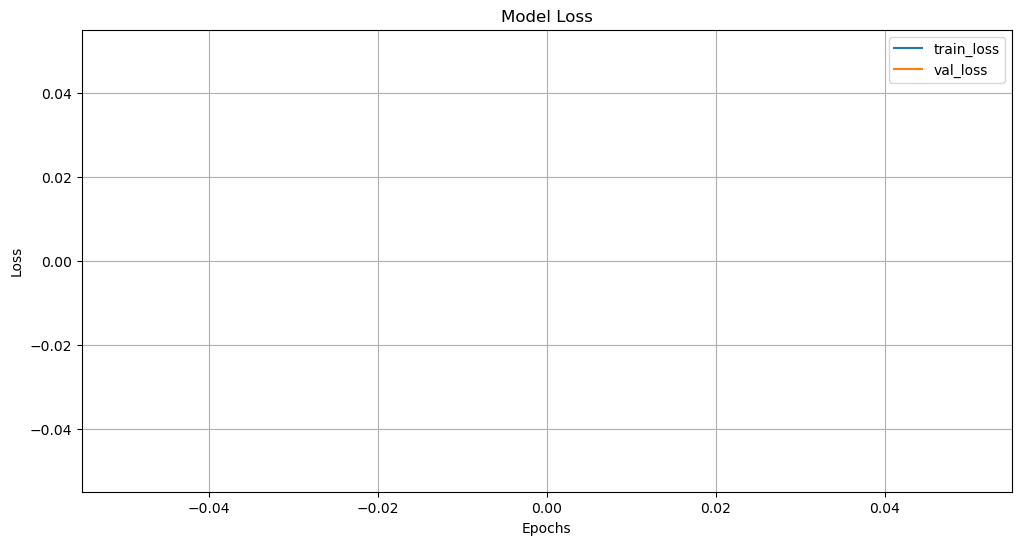

In [9]:
# history 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# 테스트 데이터에 대해 예측 수행
y_test_pred = model.predict(X_test)

# 예측된 visibility 값을 클래스(범주)로 변환
predicted_test_classes = np.array([classify_visibility(vis) for vis in y_test_pred.flatten()])

# 실제 값을 클래스(범주)로 변환
true_test_classes = np.array([classify_visibility(vis) for vis in y_test])

In [11]:
# val 몇 개 씩 들어갔는지
predicted_test_classes

array([4, 4, 4, ..., 4, 4, 4])

In [12]:
# 전체 CSI 계산 함수 정의
def calculate_csi(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP = np.diag(cm).sum()
    FN = cm.sum(axis=1) - np.diag(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    CSI = TP / (TP + FN.sum() + FP.sum())
    return CSI

# 전체 CSI 계산
csi = calculate_csi(true_test_classes, predicted_test_classes)

# CSI 출력
print(f"전체 테스트 데이터에 대한 CSI: {csi:.3f}")

전체 테스트 데이터에 대한 CSI: 0.988


In [13]:
df_test['class']

210241   NaN
210242   NaN
210243   NaN
210244   NaN
210245   NaN
          ..
262796   NaN
262797   NaN
262798   NaN
262799   NaN
262800   NaN
Name: class, Length: 52560, dtype: float64

In [14]:
model.save('model_lstm_reg.h5')

# 모델 적용

In [4]:
model = load_model('model_lstm_reg.h5')

In [5]:
df_test

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,vis1,class
210241,3,1,1,0,0,4,0.741039,0.412844,0.437931,0.0,0.472579,0.0,0.086162,0.409787,NaN,NaN
210242,3,1,1,0,10,4,0.778272,0.376147,0.434483,0.0,0.487748,0.0,0.080940,0.413802,NaN,NaN
210243,3,1,1,0,20,4,0.799944,0.376147,0.431034,0.0,0.508751,0.0,0.078329,0.420326,NaN,NaN
210244,3,1,1,0,30,4,0.763545,0.403670,0.434483,0.0,0.499417,0.0,0.080940,0.418821,NaN,NaN
210245,3,1,1,0,40,4,0.754932,0.449541,0.434483,0.0,0.507585,0.0,0.080940,0.422334,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262796,3,12,31,23,10,4,0.941373,0.559633,0.520690,0.0,0.691949,0.0,0.177546,0.564366,NaN,NaN
262797,3,12,31,23,20,4,0.931370,0.532110,0.524138,0.0,0.693116,0.0,0.177546,0.567378,NaN,NaN
262798,3,12,31,23,30,4,0.936649,0.486239,0.520690,0.0,0.701284,0.0,0.174935,0.568381,NaN,NaN
262799,3,12,31,23,40,4,0.894693,0.339450,0.513793,0.0,0.705951,0.0,0.164491,0.565370,NaN,NaN


In [11]:
# df_test의 필요한 열 선택
test_data = df_test[columns].values

# 시퀀스 생성 함수 정의 (df_test용)
def create_sequences_for_test(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# df_test에 시퀀스 생성
X_test_sequences = create_sequences_for_test(test_data, sequence_length)

In [15]:
X_test_sequences

array([[[ 3.        ,  1.        ,  1.        , ...,  0.        ,
          0.08616188,  0.4097867 ],
        [ 3.        ,  1.        ,  1.        , ...,  0.        ,
          0.08093995,  0.41380176],
        [ 3.        ,  1.        ,  1.        , ...,  0.        ,
          0.07832898,  0.42032622],
        ...,
        [ 3.        ,  1.        ,  1.        , ...,  0.        ,
          0.06005222,  0.45294856],
        [ 3.        ,  1.        ,  1.        , ...,  0.        ,
          0.06527415,  0.45395232],
        [ 3.        ,  1.        ,  1.        , ...,  0.        ,
          0.06788512,  0.4544542 ]],

       [[ 3.        ,  1.        ,  1.        , ...,  0.        ,
          0.08093995,  0.41380176],
        [ 3.        ,  1.        ,  1.        , ...,  0.        ,
          0.07832898,  0.42032622],
        [ 3.        ,  1.        ,  1.        , ...,  0.        ,
          0.08093995,  0.41882058],
        ...,
        [ 3.        ,  1.        ,  1.        , ...,  

In [21]:
# 고유 값과 그 빈도수를 계산
unique, counts = np.unique(X_test_sequences, return_counts=True)

# DataFrame으로 변환
value_counts_df = pd.DataFrame({'Value': unique, 'Count': counts})

print(value_counts_df)

           Value    Count
0       0.000000  3183912
1       0.000070       35
2       0.000096       35
3       0.000109       35
4       0.000180       35
...          ...      ...
25572  29.000000    55440
25573  30.000000   361842
25574  31.000000    34685
25575  40.000000   306402
25576  50.000000   306401

[25577 rows x 2 columns]


In [17]:
# 예측 수행
predicted_vis1 = model.predict(X_test_sequences)

In [22]:
# 고유 값과 그 빈도수를 계산
unique, counts = np.unique(predicted_vis1, return_counts=True)

# DataFrame으로 변환
value_counts_df = pd.DataFrame({'Value': unique, 'Count': counts})

print(value_counts_df)

   Value  Count
0    NaN  52526


In [13]:
# 예측된 vis1 값을 통해 클래스 분류
predicted_classes = np.array([classify_visibility(vis) for vis in predicted_vis1.flatten()])

# df_test의 'class' 열에 예측값 입력
df_test['class'] = np.nan
df_test.iloc[sequence_length-1:sequence_length-1+len(predicted_classes), df_test.columns.get_loc('class')] = predicted_classes

In [19]:
predicted_classes

array([4, 4, 4, ..., 4, 4, 4])

In [14]:
print(df_test['class'].value_counts())

4.0    52526
Name: class, dtype: int64


# 모델 합치기

In [ ]:
#### 여기까지하고 지희한테 보내기

In [107]:
# fog_test.csv부르기
df_original = pd.read_csv("fog_test.csv", index_col=1)
df_original['fog_test.class'].replace(-99, float('nan'), inplace=True)

In [108]:
# pred_A = pd.read_csv('C:\\Users\\Hong_PC\\Documents\\카카오톡 받은 파일\\240371.csv', index_col=0)
pred_C = pd.read_csv('C:\\Users\\Hong_PC\\Documents\\카카오톡 받은 파일\\240371_2번지역.csv', index_col=0)

In [109]:
# 지역 주의, 예측된 class 값만 df_original에 반영
# df_original.loc[df_original['fog_test.stn_id'].str[0] == 'A', 'fog_test.class'] = pred_A['fog_test.class'].values
# df_original.loc[df_original['fog_test.stn_id'].str[0] == 'B', 'fog_test.class'] = pred_B['class'].values
df_original.loc[df_original['fog_test.stn_id'].str[0] == 'C', 'fog_test.class'] = pred_C['class'].values
# df_original.loc[df_original['fog_test.stn_id'].str[0] == 'D', 'fog_test.class'] = pred_D['class'].values
df_original.loc[df_original['fog_test.stn_id'].str[0] == 'E', 'fog_test.class'] = pred_E['class'].values


In [110]:
df_original

,Unnamed: 0,fog_test.month,fog_test.day,fog_test.time,fog_test.minute,fog_test.stn_id,fog_test.ws10_deg,fog_test.ws10_ms,fog_test.ta,fog_test.re,fog_test.hm,fog_test.sun10,fog_test.ts,fog_test.class
fog_test.year,,,,,,,,,,,,,,
L,1,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
L,2,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
L,3,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN
L,4,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6,NaN
L,5,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L,262796,12,31,23,10,ED,338.8,6.1,4.5,0.0,71.3,0.0,1.9,4.0
L,262797,12,31,23,20,ED,335.2,5.8,4.6,0.0,71.4,0.0,1.9,4.0
L,262798,12,31,23,30,ED,337.1,5.3,4.5,0.0,72.1,0.0,1.8,4.0


In [111]:
# 혹시 결측값 있으면 4로 채움 
df_original['fog_test.class'].fillna(4, inplace=True)

In [112]:
df_original['fog_test.class'].value_counts()

4.0    262519
1.0       205
3.0        50
2.0        26
Name: fog_test.class, dtype: int64

In [102]:
df_original.to_csv('240371.csv', index=True)